In [374]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import pandas as pd
import numpy as np

import itertools

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import confusion_matrix, roc_curve, auc

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_reg = pd.read_csv('./RegularSeasonDetailedResultsEdited.csv')
df_reg.drop('Unnamed: 0', axis=1, inplace = True)

df_NCAA = pd.read_csv('./NCAATourneyCompactResults_Edited.csv')

In [3]:
df_NCAA.head(5)

,DayNum,NumOT,OppLoc,OppScore,OppTeamID,Season,TeamLoc,TeamScore,TeamTeamID,Won
0,136,0,N,54,1234,1985,N,63,1116,1
1,136,0,N,63,1116,1985,N,54,1234,0
2,136,0,N,58,1345,1985,N,59,1120,1
3,136,0,N,59,1120,1985,N,58,1345,0
4,136,0,N,43,1250,1985,N,68,1207,1


In [4]:
df_reg.head(10)

,DayNum,NumOT,OppAst,OppBlk,OppDR,OppFGA,OppFGA3,OppFGM,OppFGM3,OppFTA,...,TeamFTA,TeamFTM,TeamLoc,TeamOR,TeamPF,TeamScore,TeamStl,TeamTO,TeamTeamID,Won
0,10,0,8,2,22,53,10,22,2,22,...,18,11,N,14,22,68,7,23,1104,1
1,10,0,13,1,24,58,14,27,3,18,...,22,16,N,10,20,62,9,18,1328,0
2,10,0,7,6,25,67,24,24,6,20,...,19,10,N,15,18,70,4,13,1272,1
3,10,0,16,4,28,62,20,26,8,19,...,20,9,N,20,16,63,8,12,1393,0
4,11,0,9,5,22,73,26,22,3,23,...,29,17,N,17,25,73,5,10,1266,1
5,11,0,15,2,26,58,18,24,8,29,...,23,14,N,31,23,61,2,12,1437,0
6,11,0,9,3,20,49,22,18,6,15,...,31,17,N,6,18,56,14,12,1296,1
7,11,0,11,2,19,38,9,18,3,31,...,15,8,N,17,23,50,4,19,1457,0
8,11,0,12,1,15,62,16,24,6,27,...,13,11,N,17,20,77,4,14,1400,1
9,11,0,12,4,22,61,14,30,6,13,...,27,17,N,21,14,71,7,10,1208,0


In [5]:
df_reg_2016 = df_reg.query(" Season == '2016' ").copy()
df_reg_2017 = df_reg.query(" Season == '2017' ").copy()
df_NCAA_2017 = df_NCAA.query(" Season == '2017' ").copy()

In [6]:
df_reg_2016.columns

Index(['DayNum', 'NumOT', 'OppAst', 'OppBlk', 'OppDR', 'OppFGA', 'OppFGA3',
       'OppFGM', 'OppFGM3', 'OppFTA', 'OppFTM', 'OppLoc', 'OppOR', 'OppPF',
       'OppScore', 'OppStl', 'OppTO', 'OppTeamID', 'Season', 'TeamAst',
       'TeamBlk', 'TeamDR', 'TeamFGA', 'TeamFGA3', 'TeamFGM', 'TeamFGM3',
       'TeamFTA', 'TeamFTM', 'TeamLoc', 'TeamOR', 'TeamPF', 'TeamScore',
       'TeamStl', 'TeamTO', 'TeamTeamID', 'Won'],
      dtype='object')

In [7]:
# I dont think I need DayNum, but I'll take the stats for each team from Winner's perspective, try to groupby mean!

In [8]:
cols = [col for col in df_reg_2016.columns if col[0:4] == 'Team']
cols.append('NumOT')
cols.append('Won')

cols

['TeamAst',
 'TeamBlk',
 'TeamDR',
 'TeamFGA',
 'TeamFGA3',
 'TeamFGM',
 'TeamFGM3',
 'TeamFTA',
 'TeamFTM',
 'TeamLoc',
 'TeamOR',
 'TeamPF',
 'TeamScore',
 'TeamStl',
 'TeamTO',
 'TeamTeamID',
 'NumOT',
 'Won']

In [9]:
['2016_' + str(col) for col in cols]

['2016_TeamAst',
 '2016_TeamBlk',
 '2016_TeamDR',
 '2016_TeamFGA',
 '2016_TeamFGA3',
 '2016_TeamFGM',
 '2016_TeamFGM3',
 '2016_TeamFTA',
 '2016_TeamFTM',
 '2016_TeamLoc',
 '2016_TeamOR',
 '2016_TeamPF',
 '2016_TeamScore',
 '2016_TeamStl',
 '2016_TeamTO',
 '2016_TeamTeamID',
 '2016_NumOT',
 '2016_Won']

In [10]:
dict_2016 = {}
for item in zip(cols, ['2016_' + str(col) for col in cols]):
    dict_2016[item[0]] = item[1]

dict_2016['NumOT'] = '2016_TeamNumOT'
dict_2016['Won'] = '2016_Win_Rate'
## It might be worth trying to decompose this to WinRate at H, A, and N.


dict_2016

{'NumOT': '2016_TeamNumOT',
 'TeamAst': '2016_TeamAst',
 'TeamBlk': '2016_TeamBlk',
 'TeamDR': '2016_TeamDR',
 'TeamFGA': '2016_TeamFGA',
 'TeamFGA3': '2016_TeamFGA3',
 'TeamFGM': '2016_TeamFGM',
 'TeamFGM3': '2016_TeamFGM3',
 'TeamFTA': '2016_TeamFTA',
 'TeamFTM': '2016_TeamFTM',
 'TeamLoc': '2016_TeamLoc',
 'TeamOR': '2016_TeamOR',
 'TeamPF': '2016_TeamPF',
 'TeamScore': '2016_TeamScore',
 'TeamStl': '2016_TeamStl',
 'TeamTO': '2016_TeamTO',
 'TeamTeamID': '2016_TeamTeamID',
 'Won': '2016_Win_Rate'}

In [11]:
df_reg_2016_mean_teamstats = df_reg_2016.loc[:,cols].groupby('TeamTeamID').mean()
df_reg_2016_mean_teamstats.head()

,TeamAst,TeamBlk,TeamDR,TeamFGA,TeamFGA3,TeamFGM,TeamFGM3,TeamFTA,TeamFTM,TeamOR,TeamPF,TeamScore,TeamStl,TeamTO,NumOT,Won
TeamTeamID,,,,,,,,,,,,,,,,
1101,12.888889,2.444444,22.518519,53.925926,18.851852,23.814815,6.851852,21.740741,15.370370,8.185185,22.370370,69.851852,6.740741,13.407407,0.074074,0.333333
1102,13.033333,1.666667,25.500000,55.033333,18.866667,23.233333,6.300000,21.766667,14.666667,8.800000,19.333333,67.433333,6.100000,13.200000,0.133333,0.400000
1103,14.515152,3.848485,26.121212,59.818182,30.272727,25.939394,11.787879,18.363636,12.666667,10.303030,17.848485,76.333333,5.333333,10.818182,0.000000,0.757576
1104,10.562500,5.281250,24.875000,52.812500,22.875000,22.531250,7.843750,21.781250,13.937500,9.781250,19.312500,66.843750,5.625000,13.312500,0.062500,0.562500
1105,12.642857,2.142857,23.035714,56.178571,20.821429,23.250000,5.892857,21.571429,14.714286,11.392857,19.357143,67.107143,5.607143,11.750000,0.107143,0.357143


In [12]:
df_reg_2016_mean_teamstats.rename(index = str, columns = dict_2016, inplace = True)

In [13]:
df_reg_2016_mean_teamstats.head()

,2016_TeamAst,2016_TeamBlk,2016_TeamDR,2016_TeamFGA,2016_TeamFGA3,2016_TeamFGM,2016_TeamFGM3,2016_TeamFTA,2016_TeamFTM,2016_TeamOR,2016_TeamPF,2016_TeamScore,2016_TeamStl,2016_TeamTO,2016_TeamNumOT,2016_Win_Rate
TeamTeamID,,,,,,,,,,,,,,,,
1101,12.888889,2.444444,22.518519,53.925926,18.851852,23.814815,6.851852,21.740741,15.370370,8.185185,22.370370,69.851852,6.740741,13.407407,0.074074,0.333333
1102,13.033333,1.666667,25.500000,55.033333,18.866667,23.233333,6.300000,21.766667,14.666667,8.800000,19.333333,67.433333,6.100000,13.200000,0.133333,0.400000
1103,14.515152,3.848485,26.121212,59.818182,30.272727,25.939394,11.787879,18.363636,12.666667,10.303030,17.848485,76.333333,5.333333,10.818182,0.000000,0.757576
1104,10.562500,5.281250,24.875000,52.812500,22.875000,22.531250,7.843750,21.781250,13.937500,9.781250,19.312500,66.843750,5.625000,13.312500,0.062500,0.562500
1105,12.642857,2.142857,23.035714,56.178571,20.821429,23.250000,5.892857,21.571429,14.714286,11.392857,19.357143,67.107143,5.607143,11.750000,0.107143,0.357143


In [14]:
cols2 = [col for col in df_reg_2016.columns if col[0:3] == 'Opp']
cols2.append('NumOT')
cols2.append('Won')

df_reg_2016_mean_oppstats = df_reg_2016.loc[:,cols2].groupby('OppTeamID').mean()

dict2_2016 = {}
for item in zip(cols2, ['2016_' + str(col) for col in cols2]):
    dict2_2016[item[0]] = item[1]

dict2_2016['NumOT'] = '2016_OppNumOT'
dict2_2016['Won'] = '2016_Lose_Rate'

df_reg_2016_mean_oppstats.rename(index = str, columns = dict2_2016, inplace = True)

In [15]:
df_reg_2016_mean_oppstats.head()

,2016_OppAst,2016_OppBlk,2016_OppDR,2016_OppFGA,2016_OppFGA3,2016_OppFGM,2016_OppFGM3,2016_OppFTA,2016_OppFTM,2016_OppOR,2016_OppPF,2016_OppScore,2016_OppStl,2016_OppTO,2016_OppNumOT,2016_Lose_Rate
OppTeamID,,,,,,,,,,,,,,,,
1101,12.888889,2.444444,22.518519,53.925926,18.851852,23.814815,6.851852,21.740741,15.370370,8.185185,22.370370,69.851852,6.740741,13.407407,0.074074,0.666667
1102,13.033333,1.666667,25.500000,55.033333,18.866667,23.233333,6.300000,21.766667,14.666667,8.800000,19.333333,67.433333,6.100000,13.200000,0.133333,0.600000
1103,14.515152,3.848485,26.121212,59.818182,30.272727,25.939394,11.787879,18.363636,12.666667,10.303030,17.848485,76.333333,5.333333,10.818182,0.000000,0.242424
1104,10.562500,5.281250,24.875000,52.812500,22.875000,22.531250,7.843750,21.781250,13.937500,9.781250,19.312500,66.843750,5.625000,13.312500,0.062500,0.437500
1105,12.642857,2.142857,23.035714,56.178571,20.821429,23.250000,5.892857,21.571429,14.714286,11.392857,19.357143,67.107143,5.607143,11.750000,0.107143,0.642857


In [16]:
# Now that we have these stats, let's try to predict Reg 2017 Season wins.

In [17]:
df_reg_2017.head()

,DayNum,NumOT,OppAst,OppBlk,OppDR,OppFGA,OppFGA3,OppFGM,OppFGM3,OppFTA,...,TeamFTA,TeamFTM,TeamLoc,TeamOR,TeamPF,TeamScore,TeamStl,TeamTO,TeamTeamID,Won
142482,11,0,7,2,26,62,23,17,9,16,...,26,18,H,7,19,70,8,11,1104,1
142483,11,0,13,8,32,48,26,21,10,26,...,16,10,A,17,22,53,2,13,1157,0
142484,11,0,9,8,20,63,25,27,9,22,...,25,20,A,12,22,87,4,15,1107,1
142485,11,0,16,3,31,61,14,30,7,25,...,22,18,H,6,23,81,7,12,1336,0
142486,11,0,15,1,22,58,25,25,8,9,...,27,20,N,12,20,65,12,14,1112,1


In [18]:
# df_reg_2017['Match'] =  df_reg_2017['TeamTeamID'].astype(str).as_matrix() + "_" + df_reg_2017['OppTeamID'].astype(str).as_matrix()

In [19]:
df_reg_2017.loc[:,['TeamTeamID', 'OppTeamID', 'Won']]

,TeamTeamID,OppTeamID,Won
142482,1104,1157,1
142483,1157,1104,0
142484,1107,1336,1
142485,1336,1107,0
142486,1112,1277,1
142487,1277,1112,0
142488,1113,1340,1
142489,1340,1113,0
142490,1116,1236,1
142491,1236,1116,0


In [20]:
teamids_2017 = sorted(set(df_NCAA_2017['TeamTeamID'].tolist()))

In [21]:
len(teamids_2017)

68

In [22]:
# teamids_2017 = sorted(set(df_NCAA_2017['TeamTeamID'].tolist()))
# tourney_matches = []

# loop_ids = teamids_2017

# for team1 in loop_ids:
    
#     for team2 in loop_ids:
        
#         if team1 != team2:
            
#             tourney_matches.append(str(team1) + '_' + str(team2))
    
#     loop_ids.remove(team1)
# #     print(loop_ids)

# loop_ids = teamids_2017

In [23]:
# [*itertools.combinations(teamids_2017, 2)]

In [24]:
len(teamids_2017)

68

In [25]:
# len(tourney_matches)

In [26]:
len(list(itertools.combinations(teamids_2017,2)))

2278

In [27]:
my_set = set(itertools.combinations(teamids_2017,2))

In [30]:
# tourney_matches;

In [31]:
# teamids_2017 = sorted(set(df_NCAA_2017['TeamTeamID'].tolist()))
# tourney_matches = []

# loop_ids = teamids_2017

# for team1 in loop_ids:
    
#     for team2 in loop_ids:
        
#         if team1 != team2:
            
#             tourney_matches.append(str(team1) + '_' + str(team2))
    
#     loop_ids.remove(team1)
# #     print(len(loop_ids))

# loop_ids = teamids_2017 

In [33]:
# len(loop_ids)

In [39]:
# len(tourney_matches)

In [40]:
foo = range(68)

In [41]:
# [*map(lambda x: '_'.join(map(lambda y: str(y), x)), [*itertools.combinations(foo, 2)])]

In [42]:
# [*map(lambda x: '_'.join(map(lambda y: str(y), x)), [*itertools.combinations(teamids_2017, 2)])]

In [43]:
# tourney_matches;  # I think this should match the list for 2017 in submissionsample

In [44]:
sample_sub = pd.read_csv('./SampleSubmissionStage1.csv')

In [45]:
sample_sub.loc[sample_sub['ID'].str.contains('2017'),'ID'].tolist()

new_list = []
for item in sample_sub.loc[sample_sub['ID'].str.contains('2017'),'ID']:
    new_list.append(item[5:])

In [46]:
len(new_list)

2278

In [47]:
## Still isnt working, going to try and make list of tuples and cutout repeats?

teamids_2017 = sorted(set(df_NCAA_2017['TeamTeamID'].tolist()))
tourney_matches = []

loop_ids = teamids_2017

for team1 in loop_ids:
    
    for team2 in loop_ids:
        
        if team1 != team2:
            
            tourney_matches.append((team1,team2))
    
    loop_ids.remove(team1)
#     print(len(loop_ids))

loop_ids = teamids_2017 

In [48]:
len(tourney_matches)

1717

In [49]:
sample_sub.loc[sample_sub['ID'].str.contains('2017'),'ID'].tolist()

['2017_1112_1116',
 '2017_1112_1124',
 '2017_1112_1137',
 '2017_1112_1139',
 '2017_1112_1153',
 '2017_1112_1166',
 '2017_1112_1173',
 '2017_1112_1181',
 '2017_1112_1190',
 '2017_1112_1195',
 '2017_1112_1196',
 '2017_1112_1199',
 '2017_1112_1211',
 '2017_1112_1233',
 '2017_1112_1235',
 '2017_1112_1240',
 '2017_1112_1242',
 '2017_1112_1243',
 '2017_1112_1245',
 '2017_1112_1246',
 '2017_1112_1257',
 '2017_1112_1266',
 '2017_1112_1268',
 '2017_1112_1274',
 '2017_1112_1276',
 '2017_1112_1277',
 '2017_1112_1278',
 '2017_1112_1291',
 '2017_1112_1292',
 '2017_1112_1297',
 '2017_1112_1300',
 '2017_1112_1305',
 '2017_1112_1308',
 '2017_1112_1309',
 '2017_1112_1314',
 '2017_1112_1315',
 '2017_1112_1321',
 '2017_1112_1323',
 '2017_1112_1329',
 '2017_1112_1332',
 '2017_1112_1343',
 '2017_1112_1344',
 '2017_1112_1345',
 '2017_1112_1348',
 '2017_1112_1355',
 '2017_1112_1371',
 '2017_1112_1374',
 '2017_1112_1376',
 '2017_1112_1388',
 '2017_1112_1407',
 '2017_1112_1411',
 '2017_1112_1413',
 '2017_1112_

In [50]:
len(sample_sub.loc[sample_sub['ID'].str.contains('2017'),'ID'].tolist())

2278

In [51]:
## Will eventually have to build my test set programmatically ie Team1 Team2  Team1Stats...  Team2Stats...  Won_target.
### this way I can build each uniwue row by calling on my required asset from the groupby stats DF.

In [52]:
check_list = []
for item in sample_sub.loc[sample_sub['ID'].str.contains('2017'),'ID'].tolist():
    check_list.append((int(item[5:9]),int(item[10:])))
#     check_list.append((str(item[5:9],str(item[10:]))))
#     check_list.append(str(item[10:]))
len(sorted(set(check_list)))

2278

In [53]:
check_list

[(1112, 1116),
 (1112, 1124),
 (1112, 1137),
 (1112, 1139),
 (1112, 1153),
 (1112, 1166),
 (1112, 1173),
 (1112, 1181),
 (1112, 1190),
 (1112, 1195),
 (1112, 1196),
 (1112, 1199),
 (1112, 1211),
 (1112, 1233),
 (1112, 1235),
 (1112, 1240),
 (1112, 1242),
 (1112, 1243),
 (1112, 1245),
 (1112, 1246),
 (1112, 1257),
 (1112, 1266),
 (1112, 1268),
 (1112, 1274),
 (1112, 1276),
 (1112, 1277),
 (1112, 1278),
 (1112, 1291),
 (1112, 1292),
 (1112, 1297),
 (1112, 1300),
 (1112, 1305),
 (1112, 1308),
 (1112, 1309),
 (1112, 1314),
 (1112, 1315),
 (1112, 1321),
 (1112, 1323),
 (1112, 1329),
 (1112, 1332),
 (1112, 1343),
 (1112, 1344),
 (1112, 1345),
 (1112, 1348),
 (1112, 1355),
 (1112, 1371),
 (1112, 1374),
 (1112, 1376),
 (1112, 1388),
 (1112, 1407),
 (1112, 1411),
 (1112, 1413),
 (1112, 1417),
 (1112, 1423),
 (1112, 1425),
 (1112, 1433),
 (1112, 1435),
 (1112, 1436),
 (1112, 1437),
 (1112, 1438),
 (1112, 1439),
 (1112, 1448),
 (1112, 1452),
 (1112, 1455),
 (1112, 1457),
 (1112, 1458),
 (1112, 14

In [54]:
my_set

{(1173, 1268),
 (1153, 1411),
 (1196, 1211),
 (1199, 1246),
 (1139, 1411),
 (1413, 1462),
 (1344, 1438),
 (1274, 1292),
 (1345, 1439),
 (1315, 1433),
 (1300, 1315),
 (1139, 1277),
 (1211, 1240),
 (1371, 1455),
 (1137, 1376),
 (1195, 1277),
 (1268, 1376),
 (1274, 1407),
 (1116, 1243),
 (1153, 1246),
 (1116, 1309),
 (1173, 1277),
 (1376, 1458),
 (1245, 1355),
 (1411, 1417),
 (1343, 1433),
 (1166, 1437),
 (1374, 1435),
 (1112, 1190),
 (1297, 1332),
 (1315, 1438),
 (1166, 1243),
 (1246, 1308),
 (1211, 1233),
 (1153, 1190),
 (1137, 1305),
 (1195, 1266),
 (1343, 1407),
 (1423, 1452),
 (1246, 1455),
 (1211, 1435),
 (1153, 1388),
 (1300, 1433),
 (1291, 1315),
 (1116, 1300),
 (1153, 1437),
 (1245, 1348),
 (1124, 1153),
 (1305, 1462),
 (1323, 1388),
 (1139, 1425),
 (1137, 1153),
 (1321, 1437),
 (1292, 1425),
 (1300, 1329),
 (1211, 1315),
 (1243, 1388),
 (1190, 1278),
 (1257, 1458),
 (1181, 1274),
 (1196, 1371),
 (1240, 1413),
 (1235, 1243),
 (1343, 1423),
 (1246, 1407),
 (1355, 1435),
 (1374, 14

In [55]:
len(set(check_list) - set(my_set))

0

In [56]:
## Looks like its right now!!

In [57]:
### Trying to recreate the submission tags:

In [162]:
set(df_reg_2016['TeamTeamID'].unique()) == (set(df_reg_2017['TeamTeamID'].unique())) # Looks like the same teams played in 2016 and 2017

True

In [58]:
df_NCAA_2014 = df_NCAA.query(" Season == '2014' ").copy()
df_NCAA_2015 = df_NCAA.query(" Season == '2015' ").copy()
df_NCAA_2016 = df_NCAA.query(" Season == '2016' ").copy()
df_NCAA_2017 = df_NCAA.query(" Season == '2017' ").copy()

In [59]:
my_set = set(itertools.combinations(teamids_2017,2))

In [60]:
# Game plan :  Split winners and losers, for teamteamid and stats in winner loop concat each loser and their stats combinitorically,
# then make the match column.

In [61]:
m1 = df_reg_2016_mean_teamstats
m1.head()

,2016_TeamAst,2016_TeamBlk,2016_TeamDR,2016_TeamFGA,2016_TeamFGA3,2016_TeamFGM,2016_TeamFGM3,2016_TeamFTA,2016_TeamFTM,2016_TeamOR,2016_TeamPF,2016_TeamScore,2016_TeamStl,2016_TeamTO,2016_TeamNumOT,2016_Win_Rate
TeamTeamID,,,,,,,,,,,,,,,,
1101,12.888889,2.444444,22.518519,53.925926,18.851852,23.814815,6.851852,21.740741,15.370370,8.185185,22.370370,69.851852,6.740741,13.407407,0.074074,0.333333
1102,13.033333,1.666667,25.500000,55.033333,18.866667,23.233333,6.300000,21.766667,14.666667,8.800000,19.333333,67.433333,6.100000,13.200000,0.133333,0.400000
1103,14.515152,3.848485,26.121212,59.818182,30.272727,25.939394,11.787879,18.363636,12.666667,10.303030,17.848485,76.333333,5.333333,10.818182,0.000000,0.757576
1104,10.562500,5.281250,24.875000,52.812500,22.875000,22.531250,7.843750,21.781250,13.937500,9.781250,19.312500,66.843750,5.625000,13.312500,0.062500,0.562500
1105,12.642857,2.142857,23.035714,56.178571,20.821429,23.250000,5.892857,21.571429,14.714286,11.392857,19.357143,67.107143,5.607143,11.750000,0.107143,0.357143


In [62]:
df_reg_2016_mean_oppstats.head()

,2016_OppAst,2016_OppBlk,2016_OppDR,2016_OppFGA,2016_OppFGA3,2016_OppFGM,2016_OppFGM3,2016_OppFTA,2016_OppFTM,2016_OppOR,2016_OppPF,2016_OppScore,2016_OppStl,2016_OppTO,2016_OppNumOT,2016_Lose_Rate
OppTeamID,,,,,,,,,,,,,,,,
1101,12.888889,2.444444,22.518519,53.925926,18.851852,23.814815,6.851852,21.740741,15.370370,8.185185,22.370370,69.851852,6.740741,13.407407,0.074074,0.666667
1102,13.033333,1.666667,25.500000,55.033333,18.866667,23.233333,6.300000,21.766667,14.666667,8.800000,19.333333,67.433333,6.100000,13.200000,0.133333,0.600000
1103,14.515152,3.848485,26.121212,59.818182,30.272727,25.939394,11.787879,18.363636,12.666667,10.303030,17.848485,76.333333,5.333333,10.818182,0.000000,0.242424
1104,10.562500,5.281250,24.875000,52.812500,22.875000,22.531250,7.843750,21.781250,13.937500,9.781250,19.312500,66.843750,5.625000,13.312500,0.062500,0.437500
1105,12.642857,2.142857,23.035714,56.178571,20.821429,23.250000,5.892857,21.571429,14.714286,11.392857,19.357143,67.107143,5.607143,11.750000,0.107143,0.642857


In [63]:
# winners2017 = df_NCAA_2017.loc[df_NCAA_2017['Won'] == 1, ['TeamTeamID','DayNum','TeamLoc', 'Won']]
winners2017 = df_NCAA_2017.loc[df_NCAA_2017['Won'] == 1, ['TeamTeamID']]

In [64]:
losers2017 = df_NCAA_2017.loc[df_NCAA_2017['Won'] == 0, ['OppTeamID']]

In [65]:
winners2017.head()

,TeamTeamID
4100,1243
4102,1291
4104,1413
4106,1425
4108,1112


In [66]:
losers2017.head()

,OppTeamID
4101,1243
4103,1291
4105,1413
4107,1425
4109,1112


In [67]:
# winners2017.merge(m1, how = 'inner', right_index = True)

In [168]:
winners2017_with_2016stats = pd.merge(left = winners2017, right = df_reg_2016_mean_teamstats,\
                                      how = 'right', left_on = 'TeamTeamID', right_index = True).reset_index(drop = True)
losers2017_with_2016stats = pd.merge(left = losers2017, right = df_reg_2016_mean_oppstats,\
                                     how = 'right', left_on = 'OppTeamID', right_index = True).reset_index(drop = True)

# using a right join, I think this worked.

In [169]:
winners2017_with_2016stats.head()

,TeamTeamID,2016_TeamAst,2016_TeamBlk,2016_TeamDR,2016_TeamFGA,2016_TeamFGA3,2016_TeamFGM,2016_TeamFGM3,2016_TeamFTA,2016_TeamFTM,2016_TeamOR,2016_TeamPF,2016_TeamScore,2016_TeamStl,2016_TeamTO,2016_TeamNumOT,2016_Win_Rate
0,1101,12.888889,2.444444,22.518519,53.925926,18.851852,23.814815,6.851852,21.740741,15.370370,8.185185,22.370370,69.851852,6.740741,13.407407,0.074074,0.333333
1,1102,13.033333,1.666667,25.500000,55.033333,18.866667,23.233333,6.300000,21.766667,14.666667,8.800000,19.333333,67.433333,6.100000,13.200000,0.133333,0.400000
2,1103,14.515152,3.848485,26.121212,59.818182,30.272727,25.939394,11.787879,18.363636,12.666667,10.303030,17.848485,76.333333,5.333333,10.818182,0.000000,0.757576
3,1104,10.562500,5.281250,24.875000,52.812500,22.875000,22.531250,7.843750,21.781250,13.937500,9.781250,19.312500,66.843750,5.625000,13.312500,0.062500,0.562500
4,1105,12.642857,2.142857,23.035714,56.178571,20.821429,23.250000,5.892857,21.571429,14.714286,11.392857,19.357143,67.107143,5.607143,11.750000,0.107143,0.357143


In [170]:
losers2017_with_2016stats.head()
# Might have to convert the 'Lose Rate' to a "Opp_Win_Rate"

,OppTeamID,2016_OppAst,2016_OppBlk,2016_OppDR,2016_OppFGA,2016_OppFGA3,2016_OppFGM,2016_OppFGM3,2016_OppFTA,2016_OppFTM,2016_OppOR,2016_OppPF,2016_OppScore,2016_OppStl,2016_OppTO,2016_OppNumOT,2016_Lose_Rate
0,1101,12.888889,2.444444,22.518519,53.925926,18.851852,23.814815,6.851852,21.740741,15.370370,8.185185,22.370370,69.851852,6.740741,13.407407,0.074074,0.666667
1,1102,13.033333,1.666667,25.500000,55.033333,18.866667,23.233333,6.300000,21.766667,14.666667,8.800000,19.333333,67.433333,6.100000,13.200000,0.133333,0.600000
2,1103,14.515152,3.848485,26.121212,59.818182,30.272727,25.939394,11.787879,18.363636,12.666667,10.303030,17.848485,76.333333,5.333333,10.818182,0.000000,0.242424
3,1104,10.562500,5.281250,24.875000,52.812500,22.875000,22.531250,7.843750,21.781250,13.937500,9.781250,19.312500,66.843750,5.625000,13.312500,0.062500,0.437500
4,1105,12.642857,2.142857,23.035714,56.178571,20.821429,23.250000,5.892857,21.571429,14.714286,11.392857,19.357143,67.107143,5.607143,11.750000,0.107143,0.642857


In [171]:
winners2017.shape

(67, 1)

In [72]:
set1 = set(winners2017['TeamTeamID'].astype(int).tolist())
len(set(winners2017['TeamTeamID'].astype(int).tolist()))
# After the merge, there should still be 67 entries with 35 unique teamids. (Remember, only merging on the winners right now!)

35

In [73]:
set2 = set(m1.index.astype(int).tolist())
len(set(m1.index.astype(int).tolist()))

351

In [74]:
len(set1.intersection(set2))

35

In [75]:
set1 == set1.intersection(set2)

True

In [76]:
{'a', 'b', 'c'} - {'a', 'b'}

{'c'}

In [77]:
teamids_2017 = df_NCAA_2017['TeamTeamID'].unique().tolist()

In [78]:
set(teamids_2017)

{1112,
 1116,
 1124,
 1137,
 1139,
 1153,
 1166,
 1173,
 1181,
 1190,
 1195,
 1196,
 1199,
 1211,
 1233,
 1235,
 1240,
 1242,
 1243,
 1245,
 1246,
 1257,
 1266,
 1268,
 1274,
 1276,
 1277,
 1278,
 1291,
 1292,
 1297,
 1300,
 1305,
 1308,
 1309,
 1314,
 1315,
 1321,
 1323,
 1329,
 1332,
 1343,
 1344,
 1345,
 1348,
 1355,
 1371,
 1374,
 1376,
 1388,
 1407,
 1411,
 1413,
 1417,
 1423,
 1425,
 1433,
 1435,
 1436,
 1437,
 1438,
 1439,
 1448,
 1452,
 1455,
 1457,
 1458,
 1462}

In [79]:
set(df_NCAA_2017['OppTeamID'].unique()) == set(teamids_2017)

True

In [80]:
match_list_2017 = sorted(set(itertools.combinations(teamids_2017,2)))

In [81]:
match_pairs_2017 = []
for item in match_list_2017:
    match_pairs_2017.append(str(item[0]) + "_" + str(item[1]))
    
len(match_pairs_2017)

2278

In [82]:
match_pairs_2017

['1112_1116',
 '1112_1124',
 '1112_1137',
 '1112_1139',
 '1112_1153',
 '1112_1166',
 '1112_1173',
 '1112_1181',
 '1112_1190',
 '1112_1195',
 '1112_1196',
 '1112_1199',
 '1112_1211',
 '1112_1233',
 '1112_1235',
 '1112_1240',
 '1112_1242',
 '1112_1245',
 '1112_1246',
 '1112_1257',
 '1112_1266',
 '1112_1268',
 '1112_1274',
 '1112_1276',
 '1112_1277',
 '1112_1278',
 '1112_1292',
 '1112_1297',
 '1112_1305',
 '1112_1308',
 '1112_1314',
 '1112_1315',
 '1112_1321',
 '1112_1323',
 '1112_1329',
 '1112_1332',
 '1112_1343',
 '1112_1345',
 '1112_1348',
 '1112_1355',
 '1112_1371',
 '1112_1374',
 '1112_1376',
 '1112_1388',
 '1112_1407',
 '1112_1411',
 '1112_1417',
 '1112_1423',
 '1112_1433',
 '1112_1435',
 '1112_1436',
 '1112_1437',
 '1112_1438',
 '1112_1439',
 '1112_1452',
 '1112_1455',
 '1112_1457',
 '1112_1458',
 '1112_1462',
 '1116_1124',
 '1116_1153',
 '1116_1166',
 '1116_1173',
 '1116_1181',
 '1116_1233',
 '1116_1240',
 '1116_1242',
 '1116_1245',
 '1116_1246',
 '1116_1257',
 '1116_1266',
 '1116

In [172]:
tournament_df = pd.DataFrame({"Match" :match_pairs_2017})

tournament_df['TeamTeamID'] = tournament_df['Match'].map(lambda x: str(x[0:4]))
tournament_df['OppTeamID'] = tournament_df['Match'].map(lambda x: str(x[5:]))

In [173]:
tournament_df.shape

(2278, 3)

In [174]:
tournament_df.head()

,Match,TeamTeamID,OppTeamID
0,1112_1116,1112,1116
1,1112_1124,1112,1124
2,1112_1137,1112,1137
3,1112_1139,1112,1139
4,1112_1153,1112,1153


In [175]:
winners2017_with_2016stats.head()

,TeamTeamID,2016_TeamAst,2016_TeamBlk,2016_TeamDR,2016_TeamFGA,2016_TeamFGA3,2016_TeamFGM,2016_TeamFGM3,2016_TeamFTA,2016_TeamFTM,2016_TeamOR,2016_TeamPF,2016_TeamScore,2016_TeamStl,2016_TeamTO,2016_TeamNumOT,2016_Win_Rate
0,1101,12.888889,2.444444,22.518519,53.925926,18.851852,23.814815,6.851852,21.740741,15.370370,8.185185,22.370370,69.851852,6.740741,13.407407,0.074074,0.333333
1,1102,13.033333,1.666667,25.500000,55.033333,18.866667,23.233333,6.300000,21.766667,14.666667,8.800000,19.333333,67.433333,6.100000,13.200000,0.133333,0.400000
2,1103,14.515152,3.848485,26.121212,59.818182,30.272727,25.939394,11.787879,18.363636,12.666667,10.303030,17.848485,76.333333,5.333333,10.818182,0.000000,0.757576
3,1104,10.562500,5.281250,24.875000,52.812500,22.875000,22.531250,7.843750,21.781250,13.937500,9.781250,19.312500,66.843750,5.625000,13.312500,0.062500,0.562500
4,1105,12.642857,2.142857,23.035714,56.178571,20.821429,23.250000,5.892857,21.571429,14.714286,11.392857,19.357143,67.107143,5.607143,11.750000,0.107143,0.357143


In [176]:
losers2017_with_2016stats.head()

,OppTeamID,2016_OppAst,2016_OppBlk,2016_OppDR,2016_OppFGA,2016_OppFGA3,2016_OppFGM,2016_OppFGM3,2016_OppFTA,2016_OppFTM,2016_OppOR,2016_OppPF,2016_OppScore,2016_OppStl,2016_OppTO,2016_OppNumOT,2016_Lose_Rate
0,1101,12.888889,2.444444,22.518519,53.925926,18.851852,23.814815,6.851852,21.740741,15.370370,8.185185,22.370370,69.851852,6.740741,13.407407,0.074074,0.666667
1,1102,13.033333,1.666667,25.500000,55.033333,18.866667,23.233333,6.300000,21.766667,14.666667,8.800000,19.333333,67.433333,6.100000,13.200000,0.133333,0.600000
2,1103,14.515152,3.848485,26.121212,59.818182,30.272727,25.939394,11.787879,18.363636,12.666667,10.303030,17.848485,76.333333,5.333333,10.818182,0.000000,0.242424
3,1104,10.562500,5.281250,24.875000,52.812500,22.875000,22.531250,7.843750,21.781250,13.937500,9.781250,19.312500,66.843750,5.625000,13.312500,0.062500,0.437500
4,1105,12.642857,2.142857,23.035714,56.178571,20.821429,23.250000,5.892857,21.571429,14.714286,11.392857,19.357143,67.107143,5.607143,11.750000,0.107143,0.642857


In [177]:
t2017_merge_1 = pd.merge(left = tournament_df, right = winners2017_with_2016stats, how = 'right', left_on = 'TeamTeamID', right_on = 'TeamTeamID')

In [178]:
t2017_merge_1.shape

(2562, 19)

In [179]:
temp_df = pd.merge(left = t2017_merge_1, right = losers2017_with_2016stats, how = 'right', left_on = 'OppTeamID', right_on = 'OppTeamID')

In [180]:
temp_df.dropna(inplace = True)

In [181]:
temp_df.shape   # This matches the length of the samplesub list for 2017

(2278, 35)

In [182]:
temp_df.columns

Index(['Match', 'TeamTeamID', 'OppTeamID', '2016_TeamAst', '2016_TeamBlk',
       '2016_TeamDR', '2016_TeamFGA', '2016_TeamFGA3', '2016_TeamFGM',
       '2016_TeamFGM3', '2016_TeamFTA', '2016_TeamFTM', '2016_TeamOR',
       '2016_TeamPF', '2016_TeamScore', '2016_TeamStl', '2016_TeamTO',
       '2016_TeamNumOT', '2016_Win_Rate', '2016_OppAst', '2016_OppBlk',
       '2016_OppDR', '2016_OppFGA', '2016_OppFGA3', '2016_OppFGM',
       '2016_OppFGM3', '2016_OppFTA', '2016_OppFTM', '2016_OppOR',
       '2016_OppPF', '2016_OppScore', '2016_OppStl', '2016_OppTO',
       '2016_OppNumOT', '2016_Lose_Rate'],
      dtype='object')

In [183]:
temp_df.head()  # These are all of the possible match ups from teh NCAA 2017 Tournament.  However, I need to map the target Win column
                # to make a model, then chop off the match ups that were possible, but didnt occur.
    #The Training set will be matches we know the outcome to (use it for train/hold split), the test set will be the matches
    #that never happened
    
    # Make sure I go back and try to add the seeds from my seed mapper dictionary!

,Match,TeamTeamID,OppTeamID,2016_TeamAst,2016_TeamBlk,2016_TeamDR,2016_TeamFGA,2016_TeamFGA3,2016_TeamFGM,2016_TeamFGM3,...,2016_OppFGM3,2016_OppFTA,2016_OppFTM,2016_OppOR,2016_OppPF,2016_OppScore,2016_OppStl,2016_OppTO,2016_OppNumOT,2016_Lose_Rate
0,1112_1116,1112,1116,14.515152,4.787879,28.606061,58.242424,17.030303,28.060606,6.515152,...,6.75,23.375,16.21875,11.6875,21.46875,78.15625,7.40625,11.15625,0.15625,0.5
1,1137_1116,1137,1116,15.379310,3.137931,25.965517,57.344828,20.206897,26.241379,7.275862,...,6.75,23.375,16.21875,11.6875,21.46875,78.15625,7.40625,11.15625,0.15625,0.5
2,1139_1116,1139,1116,14.354839,3.354839,25.000000,60.129032,18.354839,28.000000,7.096774,...,6.75,23.375,16.21875,11.6875,21.46875,78.15625,7.40625,11.15625,0.15625,0.5
3,1190_1116,1190,1116,12.250000,3.562500,24.625000,58.156250,21.125000,26.812500,8.062500,...,6.75,23.375,16.21875,11.6875,21.46875,78.15625,7.40625,11.15625,0.15625,0.5
4,1195_1116,1195,1116,12.896552,4.034483,27.965517,60.068966,14.655172,28.206897,5.068966,...,6.75,23.375,16.21875,11.6875,21.46875,78.15625,7.40625,11.15625,0.15625,0.5


In [184]:
# temp_df.loc[:,[col for col in temp_df.columns if "x" in col]].head()

In [185]:
# temp_df.loc[:,[col for col in temp_df.columns if "y" in col]].head()

In [197]:
df_NCAA_2017.head()

,DayNum,NumOT,OppLoc,OppScore,OppTeamID,Season,TeamLoc,TeamScore,TeamTeamID,Won
4100,134,0,N,88,1448,2017,N,95,1243,1
4101,134,0,N,95,1243,2017,N,88,1448,0
4102,134,0,N,66,1309,2017,N,67,1291,1
4103,134,0,N,67,1291,2017,N,66,1309,0
4104,135,0,N,63,1300,2017,N,67,1413,1


In [222]:
target_df = df_NCAA_2017.loc[:,['TeamTeamID',"OppTeamID",'Won']].copy().reset_index(drop=True)

In [224]:
target_df.head(10)

,TeamTeamID,OppTeamID,Won
0,1243,1448,1
1,1448,1243,0
2,1291,1309,1
3,1309,1291,0
4,1413,1300,1
5,1300,1413,0
6,1425,1344,1
7,1344,1425,0
8,1112,1315,1
9,1315,1112,0


In [229]:
target_df.shape

(134, 3)

In [230]:
target_df['Match'] = target_df['TeamTeamID'].astype(str) + "_" + target_df['OppTeamID'].astype(str)

In [255]:
target_df.head()

,TeamTeamID,OppTeamID,Won,Match
0,1243,1448,1,1243_1448
1,1448,1243,0,1448_1243
2,1291,1309,1,1291_1309
3,1309,1291,0,1309_1291
4,1413,1300,1,1413_1300


In [236]:
target_match_won_df = target_df.loc[:,['Match','Won']].copy().reset_index(drop=True)
target_match_won_df.head(10)

,Match,Won
0,1243_1448,1
1,1448_1243,0
2,1291_1309,1
3,1309_1291,0
4,1413_1300,1
5,1300_1413,0
6,1425_1344,1
7,1344_1425,0
8,1112_1315,1
9,1315_1112,0


In [237]:
target_match_won_df.query(" Match == '1343_1323' ")

,Match,Won
25,1343_1323,0


In [248]:
model_df = pd.merge(left = temp_df, right = target_match_won_df, how = 'left', left_on = 'Match', right_on = 'Match')

In [249]:
train_df = model_df.loc[~model_df['Won'].isnull(),:]   # This is probably what I want to do for my training/holdout set
train_df.shape

(67, 36)

In [250]:
model_df.loc[model_df['Won'].isnull(),:].shape  # This could be an example test set

(2211, 36)

In [251]:
train_df.sort_values(by = 'Match').reset_index(drop = True).shape

(67, 36)

In [252]:
134/67

2.0

In [254]:
model_df

,Match,TeamTeamID,OppTeamID,2016_TeamAst,2016_TeamBlk,2016_TeamDR,2016_TeamFGA,2016_TeamFGA3,2016_TeamFGM,2016_TeamFGM3,...,2016_OppFTA,2016_OppFTM,2016_OppOR,2016_OppPF,2016_OppScore,2016_OppStl,2016_OppTO,2016_OppNumOT,2016_Lose_Rate,Won
0,1112_1116,1112,1116,14.515152,4.787879,28.606061,58.242424,17.030303,28.060606,6.515152,...,23.375000,16.218750,11.687500,21.468750,78.156250,7.406250,11.156250,0.156250,0.500000,NaN
1,1137_1116,1137,1116,15.379310,3.137931,25.965517,57.344828,20.206897,26.241379,7.275862,...,23.375000,16.218750,11.687500,21.468750,78.156250,7.406250,11.156250,0.156250,0.500000,NaN
2,1139_1116,1139,1116,14.354839,3.354839,25.000000,60.129032,18.354839,28.000000,7.096774,...,23.375000,16.218750,11.687500,21.468750,78.156250,7.406250,11.156250,0.156250,0.500000,NaN
3,1190_1116,1190,1116,12.250000,3.562500,24.625000,58.156250,21.125000,26.812500,8.062500,...,23.375000,16.218750,11.687500,21.468750,78.156250,7.406250,11.156250,0.156250,0.500000,NaN
4,1195_1116,1195,1116,12.896552,4.034483,27.965517,60.068966,14.655172,28.206897,5.068966,...,23.375000,16.218750,11.687500,21.468750,78.156250,7.406250,11.156250,0.156250,0.500000,NaN
5,1196_1116,1196,1116,13.060606,4.454545,26.969697,60.212121,22.242424,25.393939,6.939394,...,23.375000,16.218750,11.687500,21.468750,78.156250,7.406250,11.156250,0.156250,0.500000,NaN
6,1199_1116,1199,1116,13.281250,4.125000,25.437500,59.968750,19.281250,27.937500,6.687500,...,23.375000,16.218750,11.687500,21.468750,78.156250,7.406250,11.156250,0.156250,0.500000,NaN
7,1211_1116,1211,1116,13.875000,3.000000,28.906250,57.687500,20.687500,28.000000,7.781250,...,23.375000,16.218750,11.687500,21.468750,78.156250,7.406250,11.156250,0.156250,0.500000,NaN
8,1235_1116,1235,1116,16.531250,4.218750,26.968750,62.187500,21.781250,31.187500,8.281250,...,23.375000,16.218750,11.687500,21.468750,78.156250,7.406250,11.156250,0.156250,0.500000,NaN
9,1243_1116,1243,1116,13.878788,2.757576,23.212121,56.848485,17.666667,24.393939,5.303030,...,23.375000,16.218750,11.687500,21.468750,78.156250,7.406250,11.156250,0.156250,0.500000,NaN


In [265]:
df_reg_2016_mean_teamstats.head()

,2016_TeamAst,2016_TeamBlk,2016_TeamDR,2016_TeamFGA,2016_TeamFGA3,2016_TeamFGM,2016_TeamFGM3,2016_TeamFTA,2016_TeamFTM,2016_TeamOR,2016_TeamPF,2016_TeamScore,2016_TeamStl,2016_TeamTO,2016_TeamNumOT,2016_Win_Rate
TeamTeamID,,,,,,,,,,,,,,,,
1101,12.888889,2.444444,22.518519,53.925926,18.851852,23.814815,6.851852,21.740741,15.370370,8.185185,22.370370,69.851852,6.740741,13.407407,0.074074,0.333333
1102,13.033333,1.666667,25.500000,55.033333,18.866667,23.233333,6.300000,21.766667,14.666667,8.800000,19.333333,67.433333,6.100000,13.200000,0.133333,0.400000
1103,14.515152,3.848485,26.121212,59.818182,30.272727,25.939394,11.787879,18.363636,12.666667,10.303030,17.848485,76.333333,5.333333,10.818182,0.000000,0.757576
1104,10.562500,5.281250,24.875000,52.812500,22.875000,22.531250,7.843750,21.781250,13.937500,9.781250,19.312500,66.843750,5.625000,13.312500,0.062500,0.562500
1105,12.642857,2.142857,23.035714,56.178571,20.821429,23.250000,5.892857,21.571429,14.714286,11.392857,19.357143,67.107143,5.607143,11.750000,0.107143,0.357143


In [284]:
new_index = df_reg_2016_mean_teamstats.index.copy().astype(int).tolist()

In [285]:
stats_df = df_reg_2016_mean_teamstats.copy()

In [286]:
stats_df.insert(0, 'TeamTeamID', new_index)

In [287]:
stats_df.head()

,TeamTeamID,2016_TeamAst,2016_TeamBlk,2016_TeamDR,2016_TeamFGA,2016_TeamFGA3,2016_TeamFGM,2016_TeamFGM3,2016_TeamFTA,2016_TeamFTM,2016_TeamOR,2016_TeamPF,2016_TeamScore,2016_TeamStl,2016_TeamTO,2016_TeamNumOT,2016_Win_Rate
TeamTeamID,,,,,,,,,,,,,,,,,
1101,1101,12.888889,2.444444,22.518519,53.925926,18.851852,23.814815,6.851852,21.740741,15.370370,8.185185,22.370370,69.851852,6.740741,13.407407,0.074074,0.333333
1102,1102,13.033333,1.666667,25.500000,55.033333,18.866667,23.233333,6.300000,21.766667,14.666667,8.800000,19.333333,67.433333,6.100000,13.200000,0.133333,0.400000
1103,1103,14.515152,3.848485,26.121212,59.818182,30.272727,25.939394,11.787879,18.363636,12.666667,10.303030,17.848485,76.333333,5.333333,10.818182,0.000000,0.757576
1104,1104,10.562500,5.281250,24.875000,52.812500,22.875000,22.531250,7.843750,21.781250,13.937500,9.781250,19.312500,66.843750,5.625000,13.312500,0.062500,0.562500
1105,1105,12.642857,2.142857,23.035714,56.178571,20.821429,23.250000,5.892857,21.571429,14.714286,11.392857,19.357143,67.107143,5.607143,11.750000,0.107143,0.357143


In [288]:
target_df.head()

,TeamTeamID,OppTeamID,Won,Match
0,1243,1448,1,1243_1448
1,1448,1243,0,1448_1243
2,1291,1309,1,1291_1309
3,1309,1291,0,1309_1291
4,1413,1300,1,1413_1300


In [294]:
foo_df = pd.merge(left = target_df, right = stats_df, how = 'left', on = 'TeamTeamID')
bar_df = pd.merge(left = foo_df, right = stats_df, how = 'left', left_on = 'OppTeamID', right_on = 'TeamTeamID')

In [296]:
foo_df.shape

(134, 20)

In [297]:
bar_df.shape

(134, 37)

In [298]:
bar_df  ## This looks like i'ts ready for a model, Doug's method is easier than what I was doing.  Merge from stats_df twice,
        ## once on TeamTeamID and once on OppTeamID

,TeamTeamID_x,OppTeamID,Won,Match,2016_TeamAst_x,2016_TeamBlk_x,2016_TeamDR_x,2016_TeamFGA_x,2016_TeamFGA3_x,2016_TeamFGM_x,...,2016_TeamFGM3_y,2016_TeamFTA_y,2016_TeamFTM_y,2016_TeamOR_y,2016_TeamPF_y,2016_TeamScore_y,2016_TeamStl_y,2016_TeamTO_y,2016_TeamNumOT_y,2016_Win_Rate_y
0,1243,1448,1,1243_1448,13.878788,2.757576,23.212121,56.848485,17.666667,24.393939,...,6.290323,25.129032,16.580645,12.161290,20.967742,74.032258,5.935484,14.548387,0.064516,0.354839
1,1448,1243,0,1448_1243,14.000000,4.451613,26.096774,58.193548,19.935484,25.580645,...,5.303030,24.181818,16.636364,13.242424,19.969697,70.727273,7.545455,13.939394,0.151515,0.515152
2,1291,1309,1,1291_1309,10.939394,3.606061,21.333333,59.606061,21.606061,23.878788,...,5.148148,26.407407,18.185185,14.000000,21.481481,73.259259,7.666667,14.592593,0.037037,0.259259
3,1309,1291,0,1309_1291,13.074074,2.629630,23.222222,61.111111,15.851852,24.962963,...,6.848485,18.212121,12.606061,9.636364,19.848485,67.212121,7.515152,12.151515,0.090909,0.424242
4,1413,1300,1,1413_1300,11.250000,1.500000,25.035714,53.714286,15.607143,22.928571,...,6.103448,21.551724,14.275862,12.241379,19.931034,67.482759,5.448276,13.724138,0.034483,0.344828
5,1300,1413,0,1300_1413,11.793103,1.482759,24.241379,55.724138,18.000000,23.551724,...,5.607143,18.035714,11.535714,8.607143,18.071429,63.000000,6.107143,14.142857,0.178571,0.321429
6,1425,1344,1,1425_1344,14.878788,5.454545,27.454545,63.181818,20.454545,28.909091,...,7.090909,22.545455,16.393939,11.666667,16.909091,73.969697,6.636364,11.515152,0.090909,0.696970
7,1344,1425,0,1344_1425,15.909091,3.606061,24.909091,59.818182,22.090909,25.242424,...,7.878788,22.333333,15.151515,12.000000,17.454545,80.848485,6.333333,12.212121,0.121212,0.636364
8,1112,1315,1,1112_1315,14.515152,4.787879,28.606061,58.242424,17.030303,28.060606,...,6.172414,22.448276,15.310345,8.482759,21.482759,73.482759,7.551724,13.275862,0.103448,0.482759
9,1315,1112,0,1315_1112,12.931034,2.586207,27.310345,57.482759,16.931034,26.000000,...,6.515152,25.696970,18.575758,11.636364,18.212121,81.212121,4.909091,12.818182,0.181818,0.757576


In [300]:
df_NCAA_2017.shape

(134, 10)

In [316]:
train_df.corr()['Won'].sort_values()

2016_Win_Rate_y    -0.292585
2016_TeamFGM_y     -0.264649
2016_TeamScore_y   -0.263570
2016_TeamOR_y      -0.228663
2016_TeamFGA_y     -0.220664
2016_TeamAst_y     -0.199571
2016_TeamTO_x      -0.165744
2016_TeamNumOT_x   -0.099477
2016_TeamFTM_y     -0.095227
2016_TeamDR_y      -0.085103
2016_TeamBlk_y     -0.084586
2016_TeamStl_y     -0.084305
2016_TeamPF_x      -0.061458
2016_TeamFTA_y     -0.055099
2016_TeamFGA3_x    -0.050110
TeamTeamID_x       -0.044725
2016_TeamFGM3_x    -0.008167
2016_TeamFGM3_y     0.008167
TeamTeamID_y        0.044725
OppTeamID           0.044725
2016_TeamFGA3_y     0.050110
2016_TeamFTA_x      0.055099
2016_TeamPF_y       0.061458
2016_TeamStl_x      0.084305
2016_TeamBlk_x      0.084586
2016_TeamDR_x       0.085103
2016_TeamFTM_x      0.095227
2016_TeamNumOT_y    0.099477
2016_TeamTO_y       0.165744
2016_TeamAst_x      0.199571
2016_TeamFGA_x      0.220664
2016_TeamOR_x       0.228663
2016_TeamScore_x    0.263570
2016_TeamFGM_x      0.264649
2016_Win_Rate_

In [401]:
train_df = bar_df.copy()

X = train_df.drop('Won', axis = 1).copy()
y = train_df['Won'].copy()

X_train, X_hold, y_train, y_hold = train_test_split(X,y, test_size = 0.25, random_state = 1)

ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_hold = ss.transform(X_hold)

model = LogisticRegressionCV(Cs = np.logspace(-3,3,7), cv = 3)

model.fit(Xs_train, y_train)

model.score(Xs_train, y_train), model.score(Xs_hold, y_hold)

# cross_val_score(model, X_train,y_train).mean()

(0.76, 0.7058823529411765)

In [402]:
X.shape, y.shape

((134, 36), (134,))

In [403]:
pred_probs = model.predict_proba(Xs_hold)

p_lose = [item[0] for item in pred_probs]
p_win = [item[1] for item in pred_probs]

In [404]:
X_hold.Match

42     1124_1308
36     1458_1439
93     1455_1246
5      1300_1413
65     1266_1376
108    1332_1276
56     1277_1274
17     1355_1211
53     1240_1257
119    1124_1376
69     1374_1425
118    1376_1124
44     1153_1243
59     1411_1314
89     1425_1124
114    1246_1417
33     1423_1438
78     1211_1321
124    1314_1246
16     1211_1355
48     1242_1413
92     1246_1455
45     1243_1153
31     1291_1437
4      1413_1300
126    1376_1196
117    1139_1314
35     1137_1452
55     1329_1276
104    1211_1452
40     1116_1371
131    1332_1314
122    1332_1242
62     1348_1166
Name: Match, dtype: object

In [405]:
pd.DataFrame({
    "Match": X_hold.Match,
    "P_win": p_win,
    "P_lose": p_lose,
    "Actual_Win" : y_hold
})

,Actual_Win,Match,P_lose,P_win
42,1,1124_1308,0.412496,0.587504
36,1,1458_1439,0.538392,0.461608
93,0,1455_1246,0.595186,0.404814
5,0,1300_1413,0.383761,0.616239
65,0,1266_1376,0.589954,0.410046
108,1,1332_1276,0.396419,0.603581
56,1,1277_1274,0.422052,0.577948
17,0,1355_1211,0.591268,0.408732
53,0,1240_1257,0.739382,0.260618
119,0,1124_1376,0.499381,0.500619


In [406]:
confusion_matrix(y_hold, model.predict(Xs_hold))

array([[12,  4],
       [ 6, 12]])

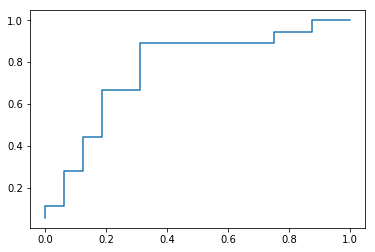

In [407]:
fpr, tpr, _ = roc_curve(y_hold, p_win)

plt.plot(fpr, tpr)

In [ ]:
## wowee!!!

In [321]:
tree = RandomForestClassifier()

tree.fit(Xs_train, y_train)

tree.score(Xs_train, y_train), tree.score(Xs_hold, y_hold)

(0.97, 0.6470588235294118)

In [352]:
X_train.shape, X_hold.shape

((100, 36), (34, 36))

In [375]:
# pd.DataFrame({
# #     "Match": ,
#     "P_win": pd.DataFrame(model.predict_proba(Xs_train))[0],
#     "P_lose": pd.DataFrame(model.predict_proba(Xs_train))[1],
#     "Actual_Win" : y_train
# })

In [334]:
pd.concat([pd.DataFrame(tree.predict_proba(Xs_train)), train_df['Match']], axis = 1)

,0,1,Match
0,0.2,0.8,1243_1448
1,0.2,0.8,1448_1243
2,0.5,0.5,1291_1309
3,1.0,0.0,1309_1291
4,0.8,0.2,1413_1300
5,0.0,1.0,1300_1413
6,0.4,0.6,1425_1344
7,0.2,0.8,1344_1425
8,0.6,0.4,1112_1315
9,0.8,0.2,1315_1112


In [329]:
knn = KNeighborsClassifier(n_neighbors= 7)

knn.fit(Xs_train, y_train)

knn.score(Xs_train, y_train), knn.score(Xs_hold, y_hold)

(0.72, 0.6764705882352942)

In [ ]:
 ## Looks like this model is working, now i need to grab the 2013-2017 data and do the same thing.  Once that is proved to be working
    # and if Kaggle will accept my submissions, then I can fine tune my model some more.
    ### Try to do this for both the reg season, NCAA tourneys, map seeds.  For the 2017 target predictions, dont use the 2017 seeds.

In [416]:
[col for col in X.columns if "Win_Rate" in col or "Match" in col]

['Match', '2016_Win_Rate_x', '2016_Win_Rate_y']

In [417]:
X.query(" Match == '1243_1448' ").loc[:,[col for col in X.columns if "Win_Rate" in col or 'Match' in col]]

,Match,2016_Win_Rate_x,2016_Win_Rate_y
0,1243_1448,0.515152,0.354839


In [418]:
X.query(" Match == '1448_1243' ").loc[:,[col for col in X.columns if "Win_Rate" in col or 'Match' in col]]

,Match,2016_Win_Rate_x,2016_Win_Rate_y
1,1448_1243,0.354839,0.515152


In [419]:
## This might be redundant, but we need to have 1's and 0's in our training set!  Or do we?  Let's try to test that now.

In [ ]:
train_df = bar_df.copy()

X = train_df.drop('Won', axis = 1).copy()
y = train_df['Won'].copy()

X_train, X_hold, y_train, y_hold = train_test_split(X,y, test_size = 0.25, random_state = 1)

ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_hold = ss.transform(X_hold)

model = LogisticRegressionCV(Cs = np.logspace(-3,3,7), cv = 3)

model.fit(Xs_train, y_train)

model.score(Xs_train, y_train), model.score(Xs_hold, y_hold)